Data Set:
**LISA Traffic Light Dataset** - [🚀](https://www.kaggle.com/mbornoe/lisa-traffic-light-dataset)  
It has more than **44 minutes** of **annotated traffic light** data.

## 1. Importing Necessary Libraries

In [253]:
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler


# Seed Everything for Reproducibility
SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

## 2. Load Data

In [254]:
DATA_PATH = '../data/LISATrafficLightDataset'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'nightSequence1',
 'nightSequence2',
 'nightTrain',
 'sample-dayClip6',
 'sample-nightClip1']

In [313]:
DAY_TRAIN_PATH = '../data/LISATrafficLightDataset/Annotations/Annotations/dayTrain/'

### Merge all different Annotation Files into a single file

**"isNight"** feature will be used to split the data so that there will be balance between **Day & Night Clips** in **Train & Test sets**

In [256]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)

df = pd.concat([train_day_df],axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 54.73it/s]


In [257]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin file,Origin frame number,Origin track,Origin track frame number
0,dayTraining/dayClip1--00000.jpg,go,698,333,710,358,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
1,dayTraining/dayClip1--00000.jpg,go,846,391,858,411,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,0
2,dayTraining/dayClip1--00001.jpg,go,698,337,710,357,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
3,dayTraining/dayClip1--00001.jpg,go,847,390,859,410,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,1
4,dayTraining/dayClip1--00002.jpg,go,698,331,710,356,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2,dayTraining/dayClip1/dayClip1Shutter0.000800-G...,2


## 3. Data Preprocessing

In [258]:
# Duplicate Columns
np.all(df['Origin file'] == df['Origin track']), np.all(df['Origin frame number'] == df['Origin track frame number'])

(True, True)

In [259]:
# Droppin duplicate columns & "Origin file" as we don't need it
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [260]:
# Here Filename (Location of Image) is different -> Change it to appropriate name
# Ex. dayTraining/dayClip1--00000.jpg -> dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg

def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [261]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [262]:
# We will change annotations to only -> stop (RED), go (GREEN) & warning (YELLOW)
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2], dtype=int64)

In [263]:
df.head()

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,Origin frame number
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,333,710,358,0
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,846,391,858,411,0
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,337,710,357,1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,847,390,859,410,1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,331,710,356,2


In [264]:
# Changing Column Names
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']

In [265]:
df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,333,710,358,0
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,846,391,858,411,0
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,337,710,357,1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,847,390,859,410,1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,331,710,356,2


## 4. Exploratory Data Analysis

In [266]:
print("Number of Unique Images: ",df.image_id.nunique(),'/',df.shape[0])

Number of Unique Images:  12775 / 37810


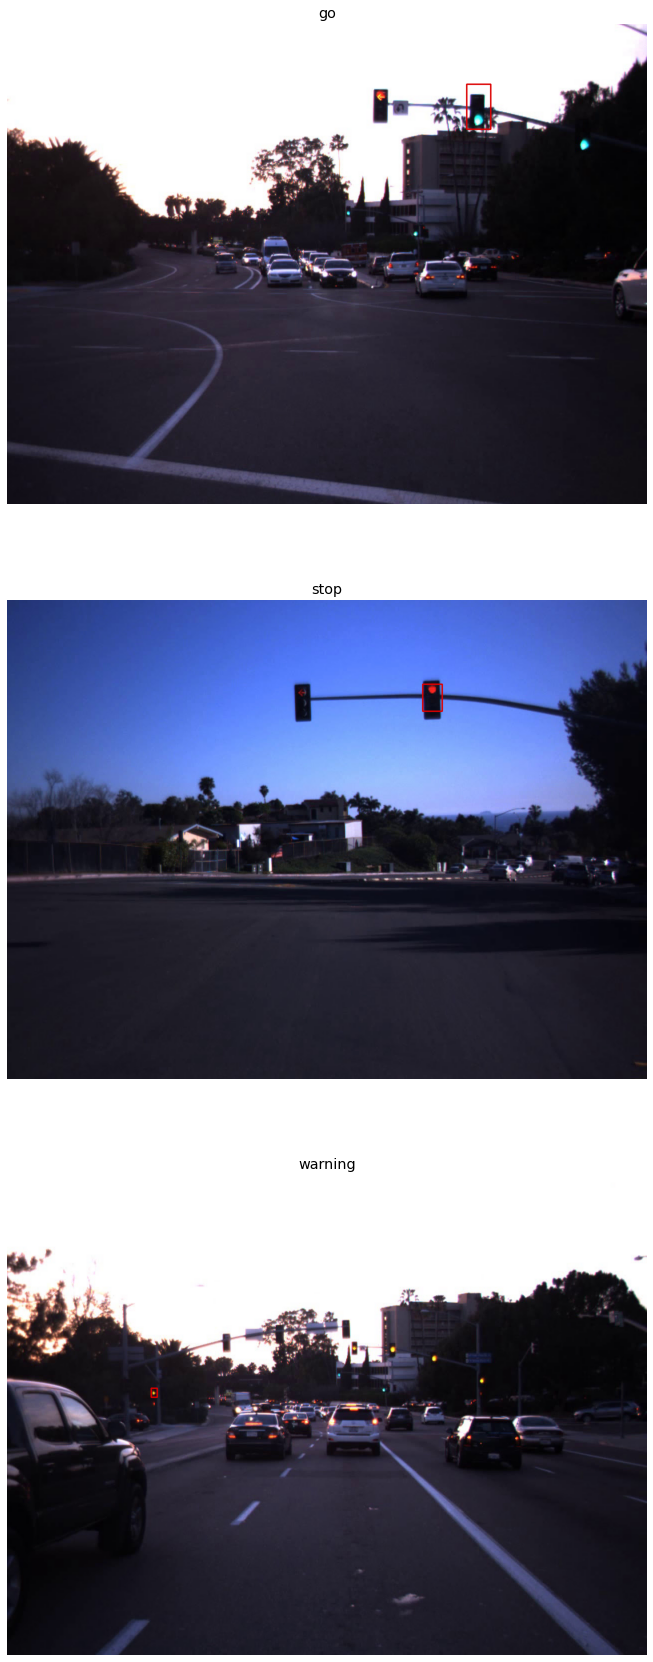

In [267]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [268]:
df[['image_id']].applymap(lambda x: x.split('/')[4])

,image_id
0,dayClip1
1,dayClip1
2,dayClip1
3,dayClip1
4,dayClip1
...,...
1935,dayClip9
1936,dayClip9
1937,dayClip9
1938,dayClip9


## 5. Validation Scheme

As we have data from multiple clips, we will have to ensure that all the images from a same clip would either be in the **train set** or in **test set**. This will ensure that, there will not be any **overlapping** between the train & the test data.

In [269]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

### Train & Test Set split

In [270]:
df = df[1:10000]

In [277]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames = testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames = trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

In [288]:
train_df, test_df = split(df)

In [289]:
df

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,846,391,858,411,0,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,337,710,357,1,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,847,390,859,410,1,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,331,710,356,2,dayClip1
5,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,848,389,860,409,2,dayClip1
...,...,...,...,...,...,...,...,...
390,../data/LISATrafficLightDataset\dayTrain/dayTr...,2,490,149,523,212,188,dayClip13
391,../data/LISATrafficLightDataset\dayTrain/dayTr...,2,942,308,966,344,189,dayClip13
392,../data/LISATrafficLightDataset\dayTrain/dayTr...,2,642,164,684,227,189,dayClip13
393,../data/LISATrafficLightDataset\dayTrain/dayTr...,2,492,158,522,203,189,dayClip13


In [290]:
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,846,391,858,411,0,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,337,710,357,1,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,847,390,859,410,1,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,331,710,356,2,dayClip1
5,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,848,389,860,409,2,dayClip1


In [291]:
test_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,150,324,168,360,0,dayClip11
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,233,334,245,352,0,dayClip11
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,346,398,364,416,0,dayClip11
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,152,323,170,354,1,dayClip11
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,348,396,366,414,1,dayClip11


In [292]:
print("Train shape: ",train_df.shape)
print("Test shape: ",test_df.shape)

Train shape:  (8739, 8)
Test shape:  (1260, 8)


### Train & Validation Split

We will do the similar thing that we did for the train-test-split above

In [293]:
train_df, val_df = split(train_df)
train_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,846,391,858,411,0,dayClip1
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,337,710,357,1,dayClip1
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,847,390,859,410,1,dayClip1
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,698,331,710,356,2,dayClip1
5,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,848,389,860,409,2,dayClip1


In [294]:
val_df.head()

,image_id,label,x_min,y_min,x_max,y_max,frame,clipNames
0,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,323,288,335,308,0,dayClip10
1,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,506,376,518,396,0,dayClip10
2,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,587,369,599,389,0,dayClip10
3,../data/LISATrafficLightDataset\dayTrain/dayTr...,3,210,261,222,279,0,dayClip10
4,../data/LISATrafficLightDataset\dayTrain/dayTr...,1,330,286,342,306,1,dayClip10


In [295]:
print("Train shape: ",train_df.shape)
print("Validation shape: ",val_df.shape)

Train shape:  (8602, 8)
Validation shape:  (137, 8)


## 6. Utils

### Configuration

In [296]:
EPOCHS = 1
BATCH_SIZE = 4

### Device

In [297]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### Custom DataSet

### Average Loss

In [298]:
# Average loss -> (Total-Loss / Total-Iterations)
class LossAverager:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [299]:
# Custom Batching with no collate function your batch data would look like:
# [(img_0, targets_0), (img_1, targets_1), ...]
# but with the collate function it would be more like
# [(img_0, img_1), (targets_0, targets_1), ...]

def collate_fn(batch):
    return tuple(zip(*batch))

### Albumentations

In [300]:
# Albumentations

# For Train Data
def getTrainTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Validation Data
def getValTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# For Test Data
def getTestTransform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [301]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        # Image_ids will be the "Filename" here
        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        # Reading Image
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # Bounding Boxes
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        # Area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Labels of the object detected
        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

### Data Loaders

In [302]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [303]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

### Checking DataPipeline

In [304]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [305]:
targets[0]

{'boxes': tensor([[264.0000, 329.6000, 268.8000, 340.2667],
         [310.8000, 311.4667, 316.8000, 324.8000],
         [335.2000, 387.2000, 347.2000, 419.2000],
         [394.8000, 371.7333, 405.6000, 398.4000],
         [462.8000, 331.7333, 472.4000, 355.7333]]),
 'labels': tensor([1, 1, 1, 1, 1]),
 'image_id': tensor([1732]),
 'area': tensor([ 240.,  375., 1800., 1350., 1080.]),
 'iscrowd': tensor([0, 0, 0, 0, 0])}

In [306]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


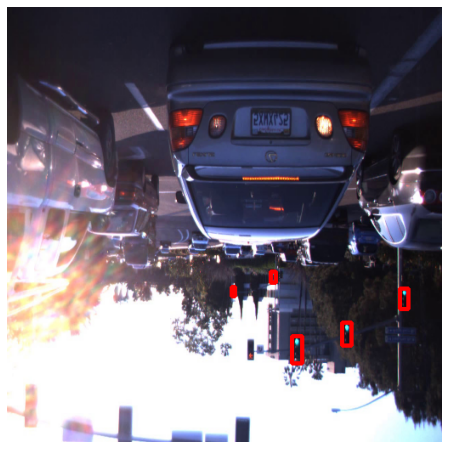

In [307]:
displayImage(image,boxes)

## 7. Model

In [308]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4  # 3 classes (Stop, Warning, Go) + Background

# Number of Input Features for the Classifier Head
INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

# New Head for Classification
model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

## 8. Training

In [309]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
# Optimizers
optimizer = torch.optim.Adam(params)

# LR Scheduler
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [310]:
import torch
torch.cuda.empty_cache()

In [311]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = '2048'
max_split_size_mb = 512

In [312]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    # LR Update
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

100%|███████████████████████████████████████████████████████████████████████████| 603/603 [22:33<00:00,  2.24s/it]


[22:34]
Epoch 0/1
Train loss: 0.2910408716557579


In [314]:
# model.load_state_dict(torch.load('../input/trafficlightdetectionfasterrcnnweights/fasterrcnn_resnet50_fpn.pth'))
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

## 9. Inference

In [315]:
model.eval()
images, targets, image_ids = next(iter(testDataLoader))
images = torch.stack(images).to(device)

outputs = model(images)

In [316]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [319]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    # Preprocessing
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


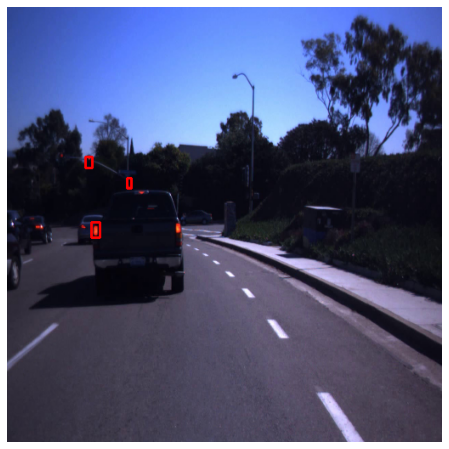

In [325]:
displayPredictions(image_ids[2],outputs[2],0.2,0.4)

## 10. Conclusion

* This could be optimized using various **Augmentation** & **Ensembling** techniques. For various Augmentations look here - [🚀](https://albumentations.ai/docs/)
* I don't know more about - **how to validate the model**. But I would be updating this notebook whenever I get to know about it. If anyone know about validating **FasterRCNN in Pytorch**, do comment below.

### 🌊 Resources:
* [Inference on Video - Notebook](https://colab.research.google.com/drive/1Zr5ozHnN9bKi6NepYVvboQ6v20i8ZO9X?usp=sharing)
* [Pytorch-Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
* [A Step-by-Step Introduction to the Basic Object Detection Algorithms](https://www.analyticsvidhya.com/blog/2018/10/a-step-by-step-introduction-to-the-basic-object-detection-algorithms-part-1/)
* [Object-Detection-on-Video](https://www.dlology.com/blog/how-to-run-object-detection-and-segmentation-on-video-fast-for-free/)
* [Albumentations](https://albumentations.ai/docs/)
* [a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection)
* [Guide to build Faster RCNN in PyTorch](https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439)
* [Object Detection for Dummies Part 3: R-CNN Family](https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html)